## ***Detection of Brain Tumor using Convolution Neural Networks***

**Group Members:**

**Group – 38:**

**Nithish Reddy Emmadi - 0754724**

**Venkata Kalyan Ram Ghatti - 0756328**

**Priya Kandula – 0754438**

**Venkata Hanuman Sai Kumar Kaparaju - 0753837**

**Harish Veeramosu - 0755976**

**Goal:** Our agenda is to build a model for detection of brain tumor using Convolutional Neural Networks.  

**Contents:**


1.   Preparation of Brain Tumor Dataset
2.   Skull Stripping
3.   Data Augmentation
2.   Building CNN Model
5. Predicting the Model with Unknown Images
6. Model Conclusion





## Importing Standard Libraries

In [ ]:
import numpy
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import imutils
from tensorflow.keras.models import Sequential
from os import listdir
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score,confusion_matrix

## Preparation of Brain Tumor images Dataset

Brain tumor images are extracted from BRATS, Kaggle and Google Images to 
prepare a Dataset.

It contains both tumor and non-tumor images.

Dataset contains 2 folders with 253 images of Brain MRI images, which comprises of 155 tumor images and 98 non-tumor images.

2 folders are classified as YES and NO, where YES folder consists images with Tumor and NO folder with 
Tumor and non-tumor images have a size of 240,240,3.



In [ ]:
!unzip -q "/content/drive/My Drive/896"

In [ ]:
!ls

brain_tumor_dataset  drive  sample_data


In [ ]:
!ls brain_tumor_dataset/

no  yes


## Dataset Creation

We are using image_dataset_from_directory method to create training, Validation, testing dataset.

We are dividing 80% of both Yes and No images data to create a training dataset.

We are dividing 20% of Yes and No images data to create validation and testing dataset.


In [ ]:
image_size = (240,240)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "brain_tumor_dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "brain_tumor_dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "brain_tumor_dataset",
    image_size=image_size,
    batch_size=30)

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.
Found 253 files belonging to 2 classes.


## Plotting of training samples

'1' is denoted as Tumor

'0' is denoted as Non-Tumor

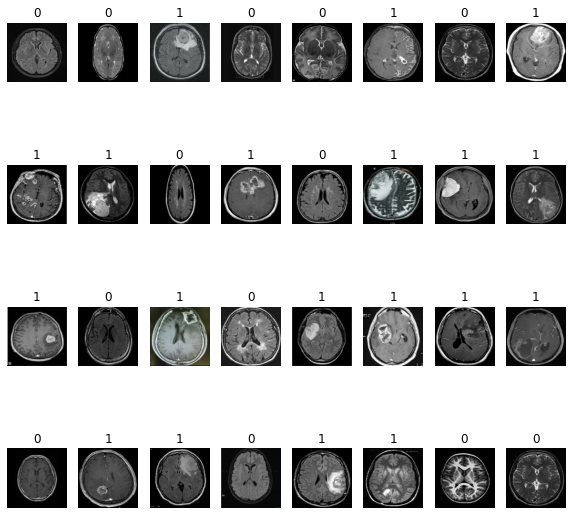

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Checking the shape of Training, Validation, Testing dataset

It has shape that consists 240*240 image size with 3 channels and a batch_size of 32

In [ ]:
for img_batch, lab_batch in train_ds:
  print(img_batch.shape)
  print(lab_batch.shape)
  break

(32, 240, 240, 3)
(32,)


In [ ]:
for img_batch, lab_batch in val_ds:
  print(img_batch.shape)
  print(lab_batch.shape)
  break

(32, 240, 240, 3)
(32,)


In [ ]:
for img_batch, lab_batch in test_ds:
  print(img_batch.shape)
  print(lab_batch.shape)
  break

(30, 240, 240, 3)
(30,)


## Class names of brain tumor dataset

In [ ]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


## **Skull Stripping**

For this skull stripping we have used cropping technique to crop outer most skull which is insignificant for our model.

We have done that by considering big contour of all images which would prevent in loss of important information from image.

This technique mainly helps in studying the images in detail. 

We have done this by using image processing library called open cv.


In [ ]:
def crop_brain_contour(image, plot=False):
    
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

## Applying Skull Striping to training dataset

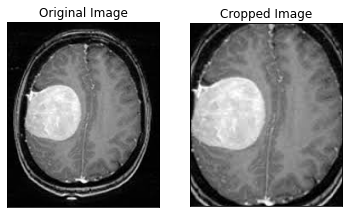

In [ ]:

ex_img = cv2.imread('/content/drive/My Drive/train/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

## **Augmentation Method**

We have used data augmentation to generate excessive data by using the existing data with different variations.

Data augumation uses methods such as Randomflipping, RandomZoom, RandomShifting  the image etc to generate the data.

By using data augumentation we have generated 980 non tumor images  and 1085 tumor images.


## Defining Augmentation Method

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(180, 
                                                              180,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Plotting of Augmented training samples

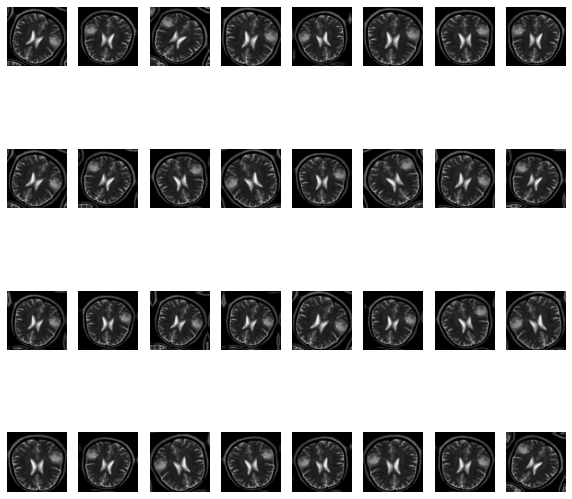

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in aug_train_ds.take(1):
    for i in range(32):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Applying Data Augmentation to training set

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

## Extracting augmented images

In [ ]:
!unzip -q "/content/drive/My Drive/aug"

In [ ]:
!ls augmented\ data

no  yes


## Preparation of Augmented images into Training, Validation, Testing dataset.

We are dividing 80% of both Yes and No images data to create a training dataset.

We are dividing 20% of Yes and No images data to create validation and testing dataset.

In [ ]:
image_size = (240,240)
batch_size = 32

aug_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "augmented data",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
aug_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "augmented data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

aug_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "augmented data",
    seed=1337,
    image_size=image_size,
    batch_size=30)

Found 2065 files belonging to 2 classes.
Using 1652 files for training.
Found 2065 files belonging to 2 classes.
Using 413 files for validation.
Found 2065 files belonging to 2 classes.


## Plotting of augmented training samples

'1' is denoted as Tumor

'0' is denoted as Non-Tumor

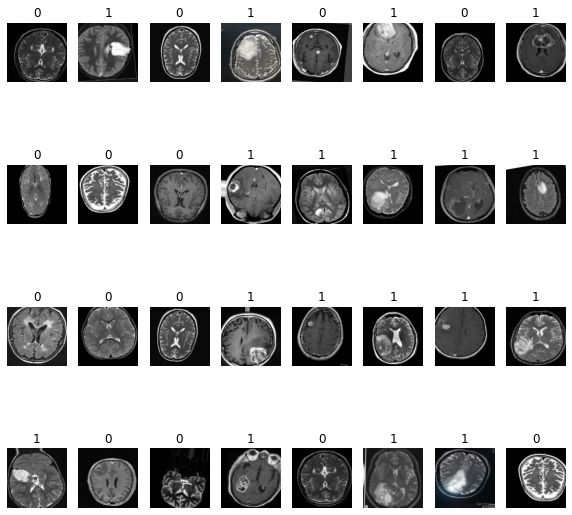

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in aug_train_ds.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## **Building CNN Model**



*   Images must be rescaled before feeding to the model.
*   We used convolution filters of size 32,64,64 and max-pooling layer of size 2*2 

*   We are using padding and strides as well to extract tumor from the images.
*   We are using dropout layer with remove deactivated neurons in our model





In [ ]:

model = models.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(240,240,3))),
model.add(layers.Conv2D(32, (3,3), padding = 'same',strides = 2,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), padding = 'same', strides = 2,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), padding = 'same', strides = 2,activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 120, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0

## Training and Compiling the Model



*   We are using adam optimizer and binary_crossentropy to compile our model
*   We are using .fit to trin our model with 50 epochs and vaildating our model as well.



In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(aug_train_ds,epochs=50,validation_data=(aug_val))

Epoch 1/50
52/52 [==============================] - 21s 400ms/step - loss: 0.6042 - accuracy: 0.6816 - val_loss: 0.7001 - val_accuracy: 0.7200
Epoch 2/50
52/52 [==============================] - 21s 395ms/step - loss: 0.5326 - accuracy: 0.7439 - val_loss: 0.6113 - val_accuracy: 0.7400
Epoch 3/50
52/52 [==============================] - 20s 391ms/step - loss: 0.4933 - accuracy: 0.7663 - val_loss: 0.6647 - val_accuracy: 0.7400
Epoch 4/50
52/52 [==============================] - 20s 389ms/step - loss: 0.4564 - accuracy: 0.7948 - val_loss: 0.6216 - val_accuracy: 0.7400
Epoch 5/50
52/52 [==============================] - 20s 389ms/step - loss: 0.3910 - accuracy: 0.8196 - val_loss: 0.5070 - val_accuracy: 0.7800
Epoch 6/50
52/52 [==============================] - 20s 390ms/step - loss: 0.3428 - accuracy: 0.8590 - val_loss: 0.4971 - val_accuracy: 0.7800
Epoch 7/50
52/52 [==============================] - 20s 390ms/step - loss: 0.2676 - accuracy: 0.8904 - val_loss: 0.7632 - val_accuracy: 0.7400

## Plotting of Accuracy

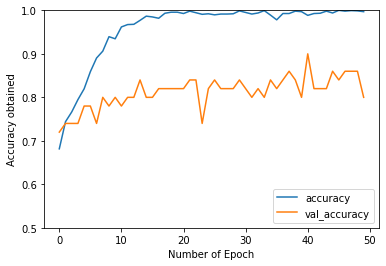

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy obtained')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Testing the Model

We are testing our model using testing dataset.

We achieved an accurracy of 96% for detection of tumor or non-tumor.

In [ ]:
test_loss, test_acc = model.evaluate(aug_test_ds,batch_size = 1,verbose=2)
print("Accuracy", test_acc)

69/69 - 11s - loss: 0.2644 - accuracy: 0.9627
Accuracy 0.9627118706703186


## Prediction of Unknow Samples

The model has predicted accurately by sending unknown samples to the network.

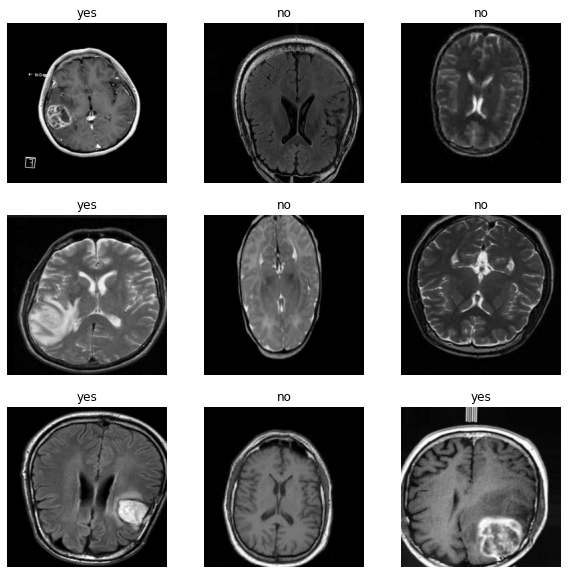

In [ ]:
image_batch, label_batch = next(iter(aug_test_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  predict_acc = model.predict(image_batch,batch_size=1)
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Prediction Accuracy

In [ ]:
predict_acc = model.predict(aug_test_ds,batch_size=1)
print("predicted Accuracy)


[[0.9999969 ]
 [0.9999155 ]
 [1.        ]
 ...
 [0.9999976 ]
 [0.00273511]
 [0.9935858 ]]


## **Model Conclusion**

We build a model for detection of Tumor and Non-tumor and achieved an accuracy of 96% with unknown samples.

Having a classification model which helps healthcare domain analyze if the patient has tumor and be able to predict it at early stages using machine learning model